In [475]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [476]:
sns.set_style("whitegrid")
sns.set_context("notebook")
pd.options.display.max_rows = 200

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

My goal in this notebook is to investigate which factors contribute to a developer's job satisfaction. With this in mind, I think that only somre of the 85 columns are actually relevant to our analysis. Furthermore, some fields contain **multiple** categorical answers, which have to be extracted and separated.

The original dataset contains 85 columns, mostly categorical. My goal in this notebook is to investigate which factors contribute to a developer's job satisfaction. With this in mind, I think that only some of the original 85 columns are actually relevant to our analysis. To avoid cluttering the notebook, I already excluded the features that I don't want to investigate further, such as the developer's learning goals for 2020 and some personal information like sexuality and ethnicity - though I decided to keep the *Gender* column.

The survey includes both a column for "Career Satisfaction" and one for "Job Satisfaction". Based on which  For example, if I choose to focus on job satisfaction I will want to exclude the "Job Seeking" column from my analysis, since that probably most people dissatisfied with their job will be activelu looking for a new one, and considering that variable would pollute the analysis.

In the end, I've decided to settle on **job satisfaction**, since I think that someone evaluating their career satisfaction would take into account a lot more variables that are harder to quantify and/or are not included in the survey.

## Importing data and initial analysis

In [477]:
survey_raw = pd.read_csv("data/survey_results_public_reduced.csv", header = 0, sep = ';', encoding = 'ISO 8859-1')

In [478]:
survey_raw.head()

,MainBranch,Hobbyist,OpenSourcer,Employment,Country,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,...,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,ImpSyn,LanguageWorkedWith,Extraversion,Age,Gender
0,I am a student who is learning to code,Yes,Never,"Not employed, and not looking for work",United Kingdom,Primary/elementary school,NaN,"Taught yourself a new language, framework, or ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,HTML/CSS;Java;JavaScript;Python,Online,14.0,Man
1,I am a student who is learning to code,No,Less than once per year,"Not employed, but looking for work",Bosnia and Herzegovina,"Secondary school (e.g. American high school, G...",NaN,Taken an online course in programming or softw...,NaN,"Developer, desktop or enterprise applications;...",...,NaN,NaN,NaN,NaN,NaN,NaN,C++;HTML/CSS;Python,Online,19.0,Man
2,"I am not primarily a developer, but I write co...",Yes,Never,Employed full-time,Thailand,"Bachelors degree (BA, BS, B.Eng., etc.)",Web development or web design,"Taught yourself a new language, framework, or ...",100 to 499 employees,"Designer;Developer, back-end;Developer, front-...",...,8820.0,40.0,There's no schedule or spec; I work on what se...,Distracting work environment;Inadequate access...,Less than once per month / Never,Average,HTML/CSS,In real life (in person),28.0,Man
3,I am a developer by profession,No,Never,Employed full-time,United States,"Bachelors degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,100 to 499 employees,"Developer, full-stack",...,61000.0,80.0,There's no schedule or spec; I work on what se...,NaN,Less than once per month / Never,A little below average,C;C++;C#;Python;SQL,In real life (in person),22.0,Man
4,I am a developer by profession,Yes,Once a month or more often,Employed full-time,Ukraine,"Bachelors degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,"10,000 or more employees","Academic researcher;Developer, desktop or ente...",...,NaN,55.0,There is a schedule and/or spec (made by me or...,Being tasked with non-development work;Inadequ...,A few days each month,A little above average,C++;HTML/CSS;Java;JavaScript;Python;SQL;VBA,In real life (in person),30.0,Man


You'll notice that in its raw form the dataset is not suitable to build a ML model, since most of the answers are categorical. Those fields will have to be properly encoded before a model can extract any insight from this data. 

However, we can stick to the predefined fields for the exploratory analysis phase.

In [479]:
print(survey_raw.columns)
print(survey_raw.info(verbose = False))

Index(['MainBranch', 'Hobbyist', 'OpenSourcer', 'Employment', 'Country',
       'EdLevel', 'UndergradMajor', 'EduOther', 'OrgSize', 'DevType',
       'YearsCode', 'Age1stCode', 'YearsCodePro', 'CareerSat', 'JobSat',
       'MgrIdiot', 'MgrMoney', 'MgrWant', 'LastHireDate', 'JobFactors',
       'ConvertedComp', 'WorkWeekHrs', 'WorkPlan', 'WorkChallenge',
       'WorkRemote', 'ImpSyn', 'LanguageWorkedWith', 'Extraversion', 'Age',
       'Gender'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88883 entries, 0 to 88882
Columns: 30 entries, MainBranch to Gender
dtypes: float64(3), object(27)
memory usage: 20.3+ MB
None


As we can see, the dataset contains almost 90000 answers to the survey. However, not all survey takers are developers: the survey also includes student, ex-devs and other categories. To figure out how many of these answers are from working developers, we can look at the *MainBranch* column.

Some of these are apparently numeric fields, that are now classified as object. This is because these fields have some text answers, like "Less than 1 year" for the "Years as a professional coder" field. 

In [480]:
survey_raw.select_dtypes(include=[float,int]).columns

Index(['ConvertedComp', 'WorkWeekHrs', 'Age'], dtype='object')

#### Selecting data of interest

I will remove from the dataset:
- People who are not currently developers (e.g. student, ex devs)
- Part-time developers
- Answers from developer with less than 1 year of coding experience (included outside of work)

This will have the added advantage of making the "YearsCode" column entirely numerical.

In [481]:
# only prof. developers
survey_dev = survey_raw[(survey_raw['MainBranch'] == 'I am a developer by profession')]

# exclude part time
survey_dev = survey_dev[(survey_dev['Employment'] == 'Employed full-time')
| (survey_dev['Employment'] == 'Independent contractor, freelancer, or self-employed') ]

# exclude less than 1 year coding
survey_dev = survey_dev[(survey_dev['YearsCodePro'] != 'Less than 1 year')]


In [482]:
survey_dev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59009 entries, 4 to 88330
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MainBranch          59009 non-null  object 
 1   Hobbyist            59009 non-null  object 
 2   OpenSourcer         59009 non-null  object 
 3   Employment          59009 non-null  object 
 4   Country             59009 non-null  object 
 5   EdLevel             57994 non-null  object 
 6   UndergradMajor      54586 non-null  object 
 7   EduOther            56528 non-null  object 
 8   OrgSize             57572 non-null  object 
 9   DevType             58480 non-null  object 
 10  YearsCode           58637 non-null  object 
 11  Age1stCode          58475 non-null  object 
 12  YearsCodePro        58547 non-null  object 
 13  CareerSat           59009 non-null  object 
 14  JobSat              58745 non-null  object 
 15  MgrIdiot            49277 non-null  object 
 16  MgrM

We've dropped about 30000 entries. Also, since Job Satisfaction is out target variable, it's best to drop the rows for which it's null - they're just a few hundred.

In [483]:
survey_dev = survey_dev[survey_dev.JobSat.notnull()]

## Exploratory data analysis

### Demographics

#### Country

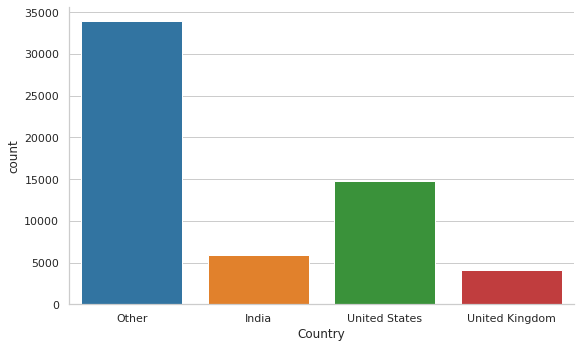

In [484]:
# Country 
survey_dev['CountryCat'] = survey_dev['Country']
survey_dev['CountryCat'] = np.where(((survey_dev['Country'] != 'United States') 
                                     & (survey_dev['Country'] != 'United Kingdom')
                                     & (survey_dev['Country'] != 'India'))
                                    , 'Other', survey_dev['Country'])
sns.catplot(x="CountryCat", kind="count", data=survey_dev, aspect = 1.6)
plt.xlabel('Country');

Let's start off with a tricky one. As you see, the majority of respondents actually aren't from the United States or UK. India is very well represented, along with other countries all over the world.
The reason this makes the analysis tricky is that it basically stops us from using the *Compensation* column as a feature for the model. Even though the compensation has been converted to US dollars for all survey respondents, it cannot give us any reliable information since the same amount of money will lead to wildly different purchasing powers in different countries.

So, I will remove the compensation column now.

In [485]:
survey_dev = survey_dev.drop(['ConvertedComp', 'CountryCat'],axis = 1)

#### Age

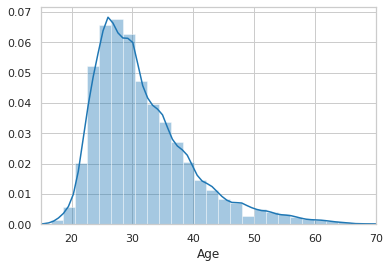

In [486]:
#Age
sns.distplot(survey_dev['Age'])
plt.xlim(15, 70);


#### Gender

In [487]:
#Gender
print(survey_dev['Gender'].value_counts() )

print('\nNumber of NULL gender values: ' + str(survey_dev['Gender'].isnull().sum()))

man_p = 100*(len(survey_dev[survey_dev['Gender'] == 'Man']) / len(survey_dev))
print('Percentage of developers who identify as men: ' + str(np.round(man_p,2)) + '%')


Man                                                            52673
Woman                                                           3664
Non-binary, genderqueer, or gender non-conforming                342
Man;Non-binary, genderqueer, or gender non-conforming            106
Woman;Non-binary, genderqueer, or gender non-conforming           84
Woman;Man                                                         50
Woman;Man;Non-binary, genderqueer, or gender non-conforming       30
Name: Gender, dtype: int64

Number of NULL gender values: 1796
Percentage of developers who identify as men: 89.66%


I don't want to remove the takers who identified as something other than Man or Woman, but to simplify the analysis I'm going to group all these other responses in an 'Other' column. I'm also going to drop the null values.

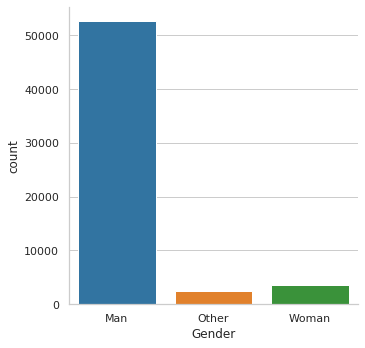

In [488]:
survey_dev['Gender'] = np.where(((survey_dev['Gender'] != 'Man') & (survey_dev['Gender'] != 'Woman')), 'Other', survey_dev['Gender'])

sns.catplot(x="Gender", kind="count", data=survey_dev)

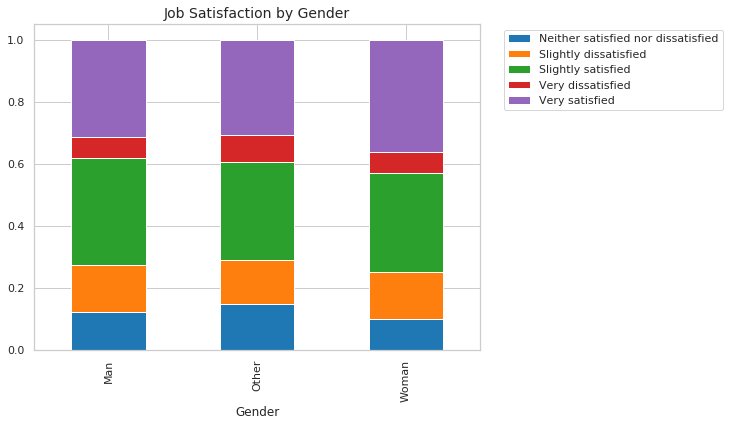

In [489]:
props = survey_dev.groupby("Gender")['JobSat'].value_counts(normalize=True).unstack()

props.plot(kind='bar', stacked='True', figsize = (8,6))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");
plt.title('Job Satisfaction by Gender',fontsize = 14);

Interestingly, there seems to be very **little difference in the distribution of job satisfaction** among genders. Women have replied "Very Satisfied" slightly more often (about 38% of all replies) than developers in the other categories (about 32%).

### Education

C:\Users\hissi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hissi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


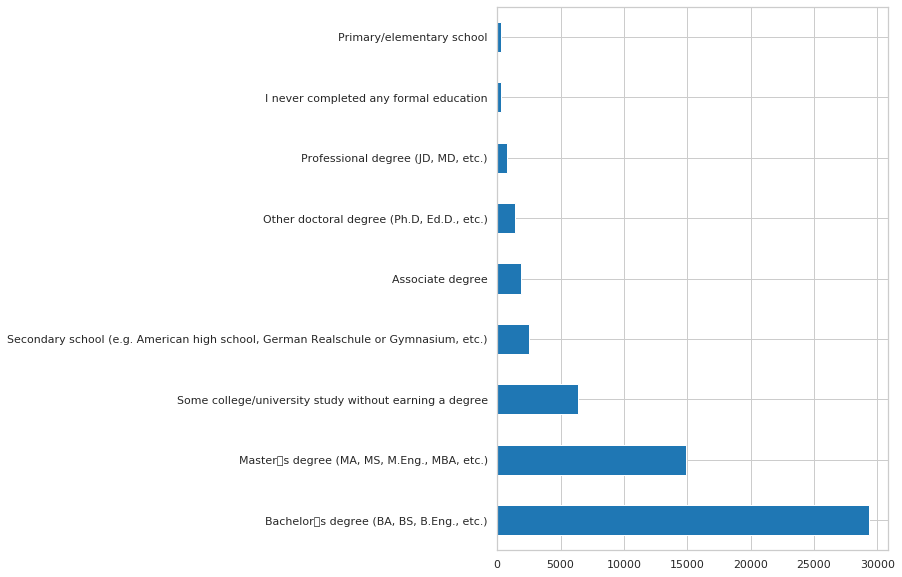

In [490]:
survey_dev['EdLevel'].value_counts().plot(kind='barh', figsize=(7,10))

There's a column that I think contains a lot of interesting information: *EduOther*. The answers come from a multiple-choice question with the possibility of choosing more than one. This last factor complicates our analysis quite a lot.


The possible answers were:
- Taken an online course in programming or software development (e.g. a MOOC)
- Contributed to open source software (this information is already included in the *OpenSourcer* column, so I will ignore it)
- Taught yourself a new language, framework, or tool without taking a formal course
- Taken a part-time in-person course in programming or software development
- Participated in a hackathon
- Completed an industry certification program (e.g. MCPD)
- Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)

Even if it clearly cannot be used as it is, this column can still come in handy for us.
In particular, I would like to create a new **self-taught** category, that includes developers who meet ALL these conditions:
- don't have a STEM degree (most non-computer science STEM programs still have at least one programming course), except for health sciences majors
- didn't participate in a bootcamp or similar in-person programs

These conditions are pretty strict: I will still consider people who took online courses as self-taught.

I'm curious to see if this new feature will show any correlation to job satisfaction.

#### Self-taught developers

In [491]:
survey_dev['UndergradMajor'].value_counts()

Computer science, computer engineering, or software engineering          36162
Another engineering discipline (ex. civil, electrical, mechanical)        4123
Information systems, information technology, or system administration     3587
Web development or web design                                             2361
A natural science (ex. biology, chemistry, physics)                       1928
Mathematics or statistics                                                 1899
A business discipline (ex. accounting, finance, marketing)                1022
A humanities discipline (ex. literature, history, philosophy)             1015
Fine arts or performing arts (ex. graphic design, music, studio art)       823
A social science (ex. anthropology, psychology, political science)         776
I never declared a major                                                   574
A health science (ex. nursing, pharmacy, radiology)                        126
Name: UndergradMajor, dtype: int64

In [492]:
not_self_taught = ((survey_dev['EduOther'].str.contains('bootcamp')) | (survey_dev['UndergradMajor'].str.contains('never'))
                        | (survey_dev['UndergradMajor'].str.contains('natural'))
                        | (survey_dev['UndergradMajor'].str.contains('computer'))
                        | (survey_dev['UndergradMajor'].str.contains('information'))
                        | (survey_dev['UndergradMajor'].str.contains('web'))
                        | (survey_dev['UndergradMajor'].str.contains('Mathematics'))
                        | (survey_dev['UndergradMajor'].str.contains('electrical')))


survey_dev = survey_dev.assign(SelfTaught=1)
survey_dev['SelfTaught'] = np.where(not_self_taught, 0, survey_dev['SelfTaught'])

In [493]:
survey_dev[survey_dev['SelfTaught'] == 1]['UndergradMajor'].value_counts()

A humanities discipline (ex. literature, history, philosophy)           761
A business discipline (ex. accounting, finance, marketing)              754
Fine arts or performing arts (ex. graphic design, music, studio art)    652
A social science (ex. anthropology, psychology, political science)      557
A health science (ex. nursing, pharmacy, radiology)                      89
I never declared a major                                                 26
Name: UndergradMajor, dtype: int64

We end up with about **6000 self-taught developers** according to our criteria.

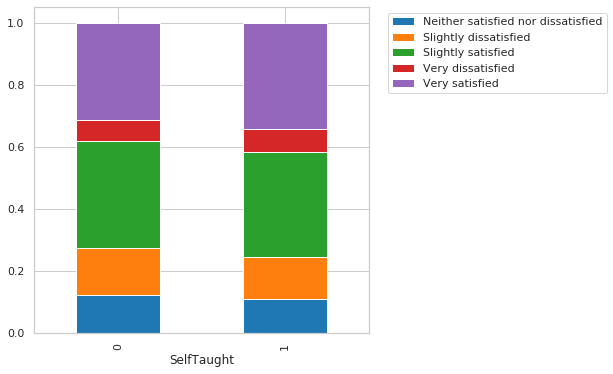

In [494]:
props_self = survey_dev.groupby("SelfTaught")['JobSat'].value_counts(normalize=True).unstack()

props_self.plot(kind='bar', stacked='True', figsize = (6,6))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");


Mmmm...seems like there's not much to see here. We will check this later when we build the model and measure relative feature importance.

#### Field of study 

Another thing I wonder is whether people who work in the field that they studied for are more satisfied than others. For developers, The "relevant" majors to consider would be (as they appear in the *UndergradMajor* column):
- Web development or web design (front-end and full-stack developers)
- Computer science, computer engineering, or software engineering 
- Information systems, information technology, or system administration 

I will also consider the subcategory of people who work in data science and studied Mathematics/Statistics, since they are technically working in their study fields.

In [495]:
survey_dev = survey_dev.assign(SameField=0)
# Developers who have relevant majors
majors = ((survey_dev['UndergradMajor'].str.contains('web')) 
        |(survey_dev['UndergradMajor'].str.contains('computer'))
        | (survey_dev['UndergradMajor'].str.contains('information')) )
# Developers working in data 
data_scientist = ((survey_dev['DevType'].str.contains('Data scientist'))
                  & (survey_dev['UndergradMajor'].str.contains('statistics')))

survey_dev['SameField'] = np.where(majors, 1, survey_dev['SameField'])
survey_dev['SameField'] = np.where(data_scientist, 1, survey_dev['SameField'])

perc_dev = np.round(100*survey_dev['SameField'].sum()/len(survey_dev))
print(str(perc_dev)+'% of developers in the survey come from a computer science or data-related major.')

72.0% of developers in the survey come from a computer science or data-related major.


In [496]:
survey_dev[survey_dev['SameField'] == 1]['UndergradMajor'].value_counts()

Computer science, computer engineering, or software engineering          36162
Information systems, information technology, or system administration     3587
Web development or web design                                             2361
Mathematics or statistics                                                  416
Name: UndergradMajor, dtype: int64

## Data wrangling

### Data types

I will try to use scikit's learn preprocessing feature as much as possible, over Pandas' analogue features. *Example*: OneHotEncoder() vs pd.get_dummies()

This provides two main advantages:
- you don't keep adding columns to your original DataFrame
- it makes the process more easily reproducible and easier to change. If you change your mind on how to encode a certain variable, in pandas you would have to remove the old column and make a new one. With scikit-learn, it's

In [497]:
browsers = ['uses Chrome', 'uses Firefox', 'uses IE', 'uses Safari']
preprocessing.OneHotEncoder(categories=[genders, locations, browsers], handle_unknown = ignore)


NameError: name 'preprocessing' is not defined

### Target value